In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['TFC','UHDRSmotor','Digit_symbol_correct','stroop_word'],
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_0_t1t2_normalized_e_TFC_UHDRSmotor_Digit_symbol_correct_stroop_word_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(701688, 832)
(701688, 8)
validation
(129856, 832)
(129856, 8)
test
(60456, 832)
(60456, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 832)]             0         


 dense (Dense)               (None, 1024)              852992    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1543048 (5.89 MB)


Trainable params: 1543048 (5.89 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/71 [..............................] - ETA: 1:28 - loss: 2.3360 - STD: 0.0704 - MAE: 0.2237

 5/71 [=>............................] - ETA: 1s - loss: 1.7339 - STD: 0.1212 - MAE: 0.1836  

 9/71 [==>...........................] - ETA: 0s - loss: 1.6128 - STD: 0.1705 - MAE: 0.1625

13/71 [====>.........................] - ETA: 0s - loss: 1.5585 - STD: 0.1782 - MAE: 0.1584

17/71 [======>.......................] - ETA: 0s - loss: 1.5290 - STD: 0.1761 - MAE: 0.1586

21/71 [=======>......................] - ETA: 0s - loss: 1.5066 - STD: 0.1776 - MAE: 0.1575

25/71 [=========>....................] - ETA: 0s - loss: 1.4908 - STD: 0.1803 - MAE: 0.1562

29/71 [===========>..................] - ETA: 0s - loss: 1.4778 - STD: 0.1808 - MAE: 0.1556

33/71 [============>.................] - ETA: 0s - loss: 1.4701 - STD: 0.1797 - MAE: 0.1559

37/71 [==============>...............] - ETA: 0s - loss: 1.4629 - STD: 0.1786 - MAE: 0.1562

40/71 [===============>..............] - ETA: 0s - loss: 1.4582 - STD: 0.1784 - MAE: 0.1561

43/71 [=================>............] - ETA: 0s - loss: 1.4548 - STD: 0.1787 - MAE: 0.1559

46/71 [==================>...........] - ETA: 0s - loss: 1.4517 - STD: 0.1791 - MAE: 0.1557

50/71 [====================>.........] - ETA: 0s - loss: 1.4477 - STD: 0.1793 - MAE: 0.1556

54/71 [=====================>........] - ETA: 0s - loss: 1.4441 - STD: 0.1791 - MAE: 0.1555

58/71 [=======================>......] - ETA: 0s - loss: 1.4410 - STD: 0.1790 - MAE: 0.1555

62/71 [=========================>....] - ETA: 0s - loss: 1.4388 - STD: 0.1790 - MAE: 0.1555

66/71 [==========================>...] - ETA: 0s - loss: 1.4365 - STD: 0.1789 - MAE: 0.1555

70/71 [============================>.] - ETA: 0s - loss: 1.4338 - STD: 0.1789 - MAE: 0.1554

71/71 [==============================] - 4s 35ms/step - loss: 1.4335 - STD: 0.1789 - MAE: 0.1554 - val_loss: 1.3312 - val_STD: 0.1802 - val_MAE: 0.1495


Epoch 2/10000


 1/71 [..............................] - ETA: 3s - loss: 1.3918 - STD: 0.1802 - MAE: 0.1537

 5/71 [=>............................] - ETA: 1s - loss: 1.3983 - STD: 0.1803 - MAE: 0.1541

 9/71 [==>...........................] - ETA: 0s - loss: 1.3993 - STD: 0.1795 - MAE: 0.1545

13/71 [====>.........................] - ETA: 0s - loss: 1.3995 - STD: 0.1790 - MAE: 0.1546

17/71 [======>.......................] - ETA: 0s - loss: 1.3989 - STD: 0.1792 - MAE: 0.1545

21/71 [=======>......................] - ETA: 0s - loss: 1.3973 - STD: 0.1792 - MAE: 0.1544

25/71 [=========>....................] - ETA: 0s - loss: 1.3967 - STD: 0.1790 - MAE: 0.1545

29/71 [===========>..................] - ETA: 0s - loss: 1.3958 - STD: 0.1789 - MAE: 0.1544

33/71 [============>.................] - ETA: 0s - loss: 1.3943 - STD: 0.1790 - MAE: 0.1543

37/71 [==============>...............] - ETA: 0s - loss: 1.3925 - STD: 0.1790 - MAE: 0.1541

41/71 [================>.............] - ETA: 0s - loss: 1.3900 - STD: 0.1790 - MAE: 0.1540

45/71 [==================>...........] - ETA: 0s - loss: 1.3869 - STD: 0.1792 - MAE: 0.1537

49/71 [===================>..........] - ETA: 0s - loss: 1.3841 - STD: 0.1793 - MAE: 0.1535

53/71 [=====================>........] - ETA: 0s - loss: 1.3810 - STD: 0.1798 - MAE: 0.1531

56/71 [======================>.......] - ETA: 0s - loss: 1.3789 - STD: 0.1800 - MAE: 0.1529

60/71 [========================>.....] - ETA: 0s - loss: 1.3759 - STD: 0.1807 - MAE: 0.1524

64/71 [==========================>...] - ETA: 0s - loss: 1.3738 - STD: 0.1810 - MAE: 0.1521

68/71 [===========================>..] - ETA: 0s - loss: 1.3704 - STD: 0.1816 - MAE: 0.1517

71/71 [==============================] - 1s 19ms/step - loss: 1.3688 - STD: 0.1818 - MAE: 0.1515 - val_loss: 1.2475 - val_STD: 0.1908 - val_MAE: 0.1395


Epoch 3/10000


 1/71 [..............................] - ETA: 3s - loss: 1.3367 - STD: 0.1921 - MAE: 0.1457

 4/71 [>.............................] - ETA: 1s - loss: 1.3219 - STD: 0.1887 - MAE: 0.1463

 8/71 [==>...........................] - ETA: 1s - loss: 1.3175 - STD: 0.1894 - MAE: 0.1458

12/71 [====>.........................] - ETA: 0s - loss: 1.3170 - STD: 0.1896 - MAE: 0.1457

16/71 [=====>........................] - ETA: 0s - loss: 1.3162 - STD: 0.1903 - MAE: 0.1454

20/71 [=======>......................] - ETA: 0s - loss: 1.3130 - STD: 0.1905 - MAE: 0.1452

24/71 [=========>....................] - ETA: 0s - loss: 1.3109 - STD: 0.1912 - MAE: 0.1447

28/71 [==========>...................] - ETA: 0s - loss: 1.3081 - STD: 0.1915 - MAE: 0.1444

32/71 [============>.................] - ETA: 0s - loss: 1.3062 - STD: 0.1918 - MAE: 0.1443

36/71 [==============>...............] - ETA: 0s - loss: 1.3043 - STD: 0.1914 - MAE: 0.1443

40/71 [===============>..............] - ETA: 0s - loss: 1.3027 - STD: 0.1913 - MAE: 0.1443

44/71 [=================>............] - ETA: 0s - loss: 1.3012 - STD: 0.1916 - MAE: 0.1442

48/71 [===================>..........] - ETA: 0s - loss: 1.2991 - STD: 0.1919 - MAE: 0.1439

52/71 [====================>.........] - ETA: 0s - loss: 1.2961 - STD: 0.1922 - MAE: 0.1437

56/71 [======================>.......] - ETA: 0s - loss: 1.2936 - STD: 0.1923 - MAE: 0.1436

60/71 [========================>.....] - ETA: 0s - loss: 1.2914 - STD: 0.1923 - MAE: 0.1435

64/71 [==========================>...] - ETA: 0s - loss: 1.2885 - STD: 0.1925 - MAE: 0.1433

68/71 [===========================>..] - ETA: 0s - loss: 1.2858 - STD: 0.1927 - MAE: 0.1431

71/71 [==============================] - 1s 19ms/step - loss: 1.2841 - STD: 0.1927 - MAE: 0.1431 - val_loss: 1.1617 - val_STD: 0.2087 - val_MAE: 0.1286


Epoch 4/10000


 1/71 [..............................] - ETA: 2s - loss: 1.2191 - STD: 0.2058 - MAE: 0.1354

 4/71 [>.............................] - ETA: 1s - loss: 1.2242 - STD: 0.1973 - MAE: 0.1390

 8/71 [==>...........................] - ETA: 1s - loss: 1.2197 - STD: 0.1976 - MAE: 0.1388

12/71 [====>.........................] - ETA: 0s - loss: 1.2174 - STD: 0.1974 - MAE: 0.1389

16/71 [=====>........................] - ETA: 0s - loss: 1.2142 - STD: 0.1971 - MAE: 0.1389

20/71 [=======>......................] - ETA: 0s - loss: 1.2071 - STD: 0.1985 - MAE: 0.1381

24/71 [=========>....................] - ETA: 0s - loss: 1.2038 - STD: 0.1987 - MAE: 0.1379

28/71 [==========>...................] - ETA: 0s - loss: 1.2000 - STD: 0.1988 - MAE: 0.1378

32/71 [============>.................] - ETA: 0s - loss: 1.1964 - STD: 0.1994 - MAE: 0.1375

36/71 [==============>...............] - ETA: 0s - loss: 1.1936 - STD: 0.1999 - MAE: 0.1372

40/71 [===============>..............] - ETA: 0s - loss: 1.1903 - STD: 0.2001 - MAE: 0.1370

44/71 [=================>............] - ETA: 0s - loss: 1.1870 - STD: 0.2004 - MAE: 0.1368

48/71 [===================>..........] - ETA: 0s - loss: 1.1848 - STD: 0.2006 - MAE: 0.1367

52/71 [====================>.........] - ETA: 0s - loss: 1.1824 - STD: 0.2009 - MAE: 0.1365

56/71 [======================>.......] - ETA: 0s - loss: 1.1798 - STD: 0.2012 - MAE: 0.1363

60/71 [========================>.....] - ETA: 0s - loss: 1.1776 - STD: 0.2014 - MAE: 0.1362

64/71 [==========================>...] - ETA: 0s - loss: 1.1749 - STD: 0.2015 - MAE: 0.1361

68/71 [===========================>..] - ETA: 0s - loss: 1.1725 - STD: 0.2016 - MAE: 0.1360

71/71 [==============================] - 1s 19ms/step - loss: 1.1704 - STD: 0.2019 - MAE: 0.1358 - val_loss: 1.0554 - val_STD: 0.1982 - val_MAE: 0.1295


Epoch 5/10000


 1/71 [..............................] - ETA: 3s - loss: 1.1320 - STD: 0.1972 - MAE: 0.1370

 5/71 [=>............................] - ETA: 1s - loss: 1.1216 - STD: 0.2039 - MAE: 0.1335

 9/71 [==>...........................] - ETA: 0s - loss: 1.1241 - STD: 0.2051 - MAE: 0.1332

13/71 [====>.........................] - ETA: 0s - loss: 1.1217 - STD: 0.2052 - MAE: 0.1330

17/71 [======>.......................] - ETA: 0s - loss: 1.1202 - STD: 0.2052 - MAE: 0.1329

21/71 [=======>......................] - ETA: 0s - loss: 1.1191 - STD: 0.2052 - MAE: 0.1330

25/71 [=========>....................] - ETA: 0s - loss: 1.1154 - STD: 0.2059 - MAE: 0.1326

29/71 [===========>..................] - ETA: 0s - loss: 1.1127 - STD: 0.2059 - MAE: 0.1325

33/71 [============>.................] - ETA: 0s - loss: 1.1097 - STD: 0.2058 - MAE: 0.1324

37/71 [==============>...............] - ETA: 0s - loss: 1.1077 - STD: 0.2061 - MAE: 0.1323

41/71 [================>.............] - ETA: 0s - loss: 1.1052 - STD: 0.2061 - MAE: 0.1322

45/71 [==================>...........] - ETA: 0s - loss: 1.1023 - STD: 0.2065 - MAE: 0.1319

49/71 [===================>..........] - ETA: 0s - loss: 1.0990 - STD: 0.2065 - MAE: 0.1318

53/71 [=====================>........] - ETA: 0s - loss: 1.0961 - STD: 0.2068 - MAE: 0.1315

57/71 [=======================>......] - ETA: 0s - loss: 1.0937 - STD: 0.2069 - MAE: 0.1314

61/71 [========================>.....] - ETA: 0s - loss: 1.0910 - STD: 0.2072 - MAE: 0.1312

65/71 [==========================>...] - ETA: 0s - loss: 1.0878 - STD: 0.2075 - MAE: 0.1309

69/71 [============================>.] - ETA: 0s - loss: 1.0848 - STD: 0.2077 - MAE: 0.1307

71/71 [==============================] - 1s 19ms/step - loss: 1.0830 - STD: 0.2079 - MAE: 0.1306 - val_loss: 0.9932 - val_STD: 0.2181 - val_MAE: 0.1201


Epoch 6/10000


 1/71 [..............................] - ETA: 2s - loss: 1.0248 - STD: 0.2179 - MAE: 0.1241

 5/71 [=>............................] - ETA: 1s - loss: 1.0220 - STD: 0.2137 - MAE: 0.1257

 9/71 [==>...........................] - ETA: 0s - loss: 1.0180 - STD: 0.2136 - MAE: 0.1255

13/71 [====>.........................] - ETA: 0s - loss: 1.0159 - STD: 0.2137 - MAE: 0.1254

17/71 [======>.......................] - ETA: 0s - loss: 1.0150 - STD: 0.2137 - MAE: 0.1255

21/71 [=======>......................] - ETA: 0s - loss: 1.0128 - STD: 0.2139 - MAE: 0.1253

25/71 [=========>....................] - ETA: 0s - loss: 1.0105 - STD: 0.2141 - MAE: 0.1252

28/71 [==========>...................] - ETA: 0s - loss: 1.0096 - STD: 0.2142 - MAE: 0.1251

32/71 [============>.................] - ETA: 0s - loss: 1.0090 - STD: 0.2143 - MAE: 0.1250

36/71 [==============>...............] - ETA: 0s - loss: 1.0080 - STD: 0.2144 - MAE: 0.1249

40/71 [===============>..............] - ETA: 0s - loss: 1.0066 - STD: 0.2149 - MAE: 0.1247

44/71 [=================>............] - ETA: 0s - loss: 1.0059 - STD: 0.2150 - MAE: 0.1246

48/71 [===================>..........] - ETA: 0s - loss: 1.0058 - STD: 0.2152 - MAE: 0.1245

52/71 [====================>.........] - ETA: 0s - loss: 1.0041 - STD: 0.2153 - MAE: 0.1245

56/71 [======================>.......] - ETA: 0s - loss: 1.0028 - STD: 0.2155 - MAE: 0.1243

60/71 [========================>.....] - ETA: 0s - loss: 1.0019 - STD: 0.2156 - MAE: 0.1242

64/71 [==========================>...] - ETA: 0s - loss: 1.0005 - STD: 0.2157 - MAE: 0.1241

68/71 [===========================>..] - ETA: 0s - loss: 0.9990 - STD: 0.2159 - MAE: 0.1240

71/71 [==============================] - 1s 19ms/step - loss: 0.9978 - STD: 0.2160 - MAE: 0.1239 - val_loss: 0.9650 - val_STD: 0.2256 - val_MAE: 0.1159


Epoch 7/10000


 1/71 [..............................] - ETA: 3s - loss: 0.9818 - STD: 0.2258 - MAE: 0.1191

 5/71 [=>............................] - ETA: 1s - loss: 0.9743 - STD: 0.2196 - MAE: 0.1214

 9/71 [==>...........................] - ETA: 1s - loss: 0.9722 - STD: 0.2196 - MAE: 0.1213

13/71 [====>.........................] - ETA: 0s - loss: 0.9662 - STD: 0.2202 - MAE: 0.1208

17/71 [======>.......................] - ETA: 0s - loss: 0.9684 - STD: 0.2198 - MAE: 0.1211

21/71 [=======>......................] - ETA: 0s - loss: 0.9692 - STD: 0.2200 - MAE: 0.1210

25/71 [=========>....................] - ETA: 0s - loss: 0.9687 - STD: 0.2197 - MAE: 0.1212

29/71 [===========>..................] - ETA: 0s - loss: 0.9683 - STD: 0.2197 - MAE: 0.1212

33/71 [============>.................] - ETA: 0s - loss: 0.9673 - STD: 0.2196 - MAE: 0.1211

37/71 [==============>...............] - ETA: 0s - loss: 0.9662 - STD: 0.2201 - MAE: 0.1209

41/71 [================>.............] - ETA: 0s - loss: 0.9661 - STD: 0.2198 - MAE: 0.1210

45/71 [==================>...........] - ETA: 0s - loss: 0.9647 - STD: 0.2200 - MAE: 0.1209

49/71 [===================>..........] - ETA: 0s - loss: 0.9644 - STD: 0.2202 - MAE: 0.1208

53/71 [=====================>........] - ETA: 0s - loss: 0.9637 - STD: 0.2201 - MAE: 0.1208

57/71 [=======================>......] - ETA: 0s - loss: 0.9631 - STD: 0.2202 - MAE: 0.1207

61/71 [========================>.....] - ETA: 0s - loss: 0.9626 - STD: 0.2202 - MAE: 0.1207

65/71 [==========================>...] - ETA: 0s - loss: 0.9624 - STD: 0.2203 - MAE: 0.1207

69/71 [============================>.] - ETA: 0s - loss: 0.9615 - STD: 0.2204 - MAE: 0.1206

71/71 [==============================] - 1s 19ms/step - loss: 0.9610 - STD: 0.2205 - MAE: 0.1205 - val_loss: 0.9766 - val_STD: 0.2134 - val_MAE: 0.1224


Epoch 8/10000


 1/71 [..............................] - ETA: 3s - loss: 0.9620 - STD: 0.2127 - MAE: 0.1239

 5/71 [=>............................] - ETA: 1s - loss: 0.9495 - STD: 0.2213 - MAE: 0.1196

 9/71 [==>...........................] - ETA: 0s - loss: 0.9530 - STD: 0.2220 - MAE: 0.1195

13/71 [====>.........................] - ETA: 0s - loss: 0.9481 - STD: 0.2220 - MAE: 0.1193

17/71 [======>.......................] - ETA: 0s - loss: 0.9481 - STD: 0.2218 - MAE: 0.1194

21/71 [=======>......................] - ETA: 0s - loss: 0.9466 - STD: 0.2221 - MAE: 0.1192

25/71 [=========>....................] - ETA: 0s - loss: 0.9452 - STD: 0.2220 - MAE: 0.1192

29/71 [===========>..................] - ETA: 0s - loss: 0.9452 - STD: 0.2221 - MAE: 0.1191

33/71 [============>.................] - ETA: 0s - loss: 0.9453 - STD: 0.2220 - MAE: 0.1192

37/71 [==============>...............] - ETA: 0s - loss: 0.9463 - STD: 0.2222 - MAE: 0.1192

41/71 [================>.............] - ETA: 0s - loss: 0.9457 - STD: 0.2222 - MAE: 0.1192

45/71 [==================>...........] - ETA: 0s - loss: 0.9441 - STD: 0.2222 - MAE: 0.1191

49/71 [===================>..........] - ETA: 0s - loss: 0.9430 - STD: 0.2223 - MAE: 0.1190

53/71 [=====================>........] - ETA: 0s - loss: 0.9423 - STD: 0.2224 - MAE: 0.1190

57/71 [=======================>......] - ETA: 0s - loss: 0.9414 - STD: 0.2225 - MAE: 0.1189

61/71 [========================>.....] - ETA: 0s - loss: 0.9406 - STD: 0.2226 - MAE: 0.1188

65/71 [==========================>...] - ETA: 0s - loss: 0.9400 - STD: 0.2225 - MAE: 0.1188

69/71 [============================>.] - ETA: 0s - loss: 0.9404 - STD: 0.2226 - MAE: 0.1188

71/71 [==============================] - 1s 18ms/step - loss: 0.9404 - STD: 0.2225 - MAE: 0.1189 - val_loss: 0.9419 - val_STD: 0.2255 - val_MAE: 0.1153


Epoch 9/10000


 1/71 [..............................] - ETA: 3s - loss: 0.9380 - STD: 0.2248 - MAE: 0.1183

 5/71 [=>............................] - ETA: 1s - loss: 0.9328 - STD: 0.2251 - MAE: 0.1176

 9/71 [==>...........................] - ETA: 0s - loss: 0.9334 - STD: 0.2241 - MAE: 0.1180

13/71 [====>.........................] - ETA: 0s - loss: 0.9294 - STD: 0.2235 - MAE: 0.1181

17/71 [======>.......................] - ETA: 0s - loss: 0.9280 - STD: 0.2233 - MAE: 0.1181

21/71 [=======>......................] - ETA: 0s - loss: 0.9275 - STD: 0.2235 - MAE: 0.1180

25/71 [=========>....................] - ETA: 0s - loss: 0.9259 - STD: 0.2238 - MAE: 0.1177

30/71 [===========>..................] - ETA: 0s - loss: 0.9247 - STD: 0.2237 - MAE: 0.1177

34/71 [=============>................] - ETA: 0s - loss: 0.9250 - STD: 0.2238 - MAE: 0.1177

38/71 [===============>..............] - ETA: 0s - loss: 0.9258 - STD: 0.2238 - MAE: 0.1178

42/71 [================>.............] - ETA: 0s - loss: 0.9262 - STD: 0.2241 - MAE: 0.1176

46/71 [==================>...........] - ETA: 0s - loss: 0.9260 - STD: 0.2243 - MAE: 0.1175

50/71 [====================>.........] - ETA: 0s - loss: 0.9254 - STD: 0.2241 - MAE: 0.1176

54/71 [=====================>........] - ETA: 0s - loss: 0.9247 - STD: 0.2241 - MAE: 0.1176

58/71 [=======================>......] - ETA: 0s - loss: 0.9244 - STD: 0.2241 - MAE: 0.1175

62/71 [=========================>....] - ETA: 0s - loss: 0.9234 - STD: 0.2242 - MAE: 0.1175

66/71 [==========================>...] - ETA: 0s - loss: 0.9221 - STD: 0.2243 - MAE: 0.1174

70/71 [============================>.] - ETA: 0s - loss: 0.9211 - STD: 0.2244 - MAE: 0.1173

71/71 [==============================] - 1s 19ms/step - loss: 0.9208 - STD: 0.2244 - MAE: 0.1172 - val_loss: 0.9370 - val_STD: 0.2279 - val_MAE: 0.1142


Epoch 10/10000


 1/71 [..............................] - ETA: 3s - loss: 0.8987 - STD: 0.2271 - MAE: 0.1150

 5/71 [=>............................] - ETA: 1s - loss: 0.9044 - STD: 0.2253 - MAE: 0.1160

 9/71 [==>...........................] - ETA: 0s - loss: 0.9032 - STD: 0.2260 - MAE: 0.1157

13/71 [====>.........................] - ETA: 0s - loss: 0.9014 - STD: 0.2257 - MAE: 0.1158

17/71 [======>.......................] - ETA: 0s - loss: 0.9055 - STD: 0.2254 - MAE: 0.1161

21/71 [=======>......................] - ETA: 0s - loss: 0.9075 - STD: 0.2260 - MAE: 0.1159

25/71 [=========>....................] - ETA: 0s - loss: 0.9106 - STD: 0.2259 - MAE: 0.1161

29/71 [===========>..................] - ETA: 0s - loss: 0.9099 - STD: 0.2256 - MAE: 0.1162

33/71 [============>.................] - ETA: 0s - loss: 0.9082 - STD: 0.2257 - MAE: 0.1161

37/71 [==============>...............] - ETA: 0s - loss: 0.9067 - STD: 0.2259 - MAE: 0.1159

41/71 [================>.............] - ETA: 0s - loss: 0.9062 - STD: 0.2258 - MAE: 0.1159

45/71 [==================>...........] - ETA: 0s - loss: 0.9047 - STD: 0.2259 - MAE: 0.1158

49/71 [===================>..........] - ETA: 0s - loss: 0.9043 - STD: 0.2260 - MAE: 0.1157

53/71 [=====================>........] - ETA: 0s - loss: 0.9042 - STD: 0.2260 - MAE: 0.1157

57/71 [=======================>......] - ETA: 0s - loss: 0.9040 - STD: 0.2261 - MAE: 0.1157

61/71 [========================>.....] - ETA: 0s - loss: 0.9039 - STD: 0.2260 - MAE: 0.1157

65/71 [==========================>...] - ETA: 0s - loss: 0.9038 - STD: 0.2262 - MAE: 0.1156

69/71 [============================>.] - ETA: 0s - loss: 0.9043 - STD: 0.2262 - MAE: 0.1157

71/71 [==============================] - 1s 18ms/step - loss: 0.9039 - STD: 0.2262 - MAE: 0.1157 - val_loss: 0.9725 - val_STD: 0.2271 - val_MAE: 0.1158


Epoch 11/10000


 1/71 [..............................] - ETA: 3s - loss: 0.9230 - STD: 0.2265 - MAE: 0.1164

 5/71 [=>............................] - ETA: 1s - loss: 0.9118 - STD: 0.2259 - MAE: 0.1160

 9/71 [==>...........................] - ETA: 0s - loss: 0.9123 - STD: 0.2266 - MAE: 0.1157

13/71 [====>.........................] - ETA: 0s - loss: 0.9062 - STD: 0.2272 - MAE: 0.1152

17/71 [======>.......................] - ETA: 0s - loss: 0.9070 - STD: 0.2268 - MAE: 0.1154

21/71 [=======>......................] - ETA: 0s - loss: 0.9048 - STD: 0.2268 - MAE: 0.1153

25/71 [=========>....................] - ETA: 0s - loss: 0.9010 - STD: 0.2270 - MAE: 0.1150

29/71 [===========>..................] - ETA: 0s - loss: 0.8993 - STD: 0.2273 - MAE: 0.1148

33/71 [============>.................] - ETA: 0s - loss: 0.8980 - STD: 0.2272 - MAE: 0.1149

37/71 [==============>...............] - ETA: 0s - loss: 0.8985 - STD: 0.2273 - MAE: 0.1149

41/71 [================>.............] - ETA: 0s - loss: 0.8987 - STD: 0.2270 - MAE: 0.1150

45/71 [==================>...........] - ETA: 0s - loss: 0.8985 - STD: 0.2272 - MAE: 0.1149

49/71 [===================>..........] - ETA: 0s - loss: 0.8978 - STD: 0.2271 - MAE: 0.1149

53/71 [=====================>........] - ETA: 0s - loss: 0.8969 - STD: 0.2272 - MAE: 0.1149

57/71 [=======================>......] - ETA: 0s - loss: 0.8965 - STD: 0.2272 - MAE: 0.1148

61/71 [========================>.....] - ETA: 0s - loss: 0.8959 - STD: 0.2272 - MAE: 0.1148

65/71 [==========================>...] - ETA: 0s - loss: 0.8952 - STD: 0.2273 - MAE: 0.1147

69/71 [============================>.] - ETA: 0s - loss: 0.8944 - STD: 0.2272 - MAE: 0.1147

71/71 [==============================] - 1s 19ms/step - loss: 0.8941 - STD: 0.2273 - MAE: 0.1147 - val_loss: 0.9284 - val_STD: 0.2306 - val_MAE: 0.1130


Epoch 12/10000


 1/71 [..............................] - ETA: 2s - loss: 0.8781 - STD: 0.2309 - MAE: 0.1124

 4/71 [>.............................] - ETA: 1s - loss: 0.8894 - STD: 0.2288 - MAE: 0.1140

 8/71 [==>...........................] - ETA: 1s - loss: 0.8851 - STD: 0.2285 - MAE: 0.1138

12/71 [====>.........................] - ETA: 0s - loss: 0.8869 - STD: 0.2281 - MAE: 0.1141

16/71 [=====>........................] - ETA: 0s - loss: 0.8853 - STD: 0.2283 - MAE: 0.1139

20/71 [=======>......................] - ETA: 0s - loss: 0.8844 - STD: 0.2277 - MAE: 0.1142

24/71 [=========>....................] - ETA: 0s - loss: 0.8857 - STD: 0.2284 - MAE: 0.1140

28/71 [==========>...................] - ETA: 0s - loss: 0.8833 - STD: 0.2283 - MAE: 0.1139

32/71 [============>.................] - ETA: 0s - loss: 0.8824 - STD: 0.2282 - MAE: 0.1138

36/71 [==============>...............] - ETA: 0s - loss: 0.8821 - STD: 0.2284 - MAE: 0.1138

40/71 [===============>..............] - ETA: 0s - loss: 0.8825 - STD: 0.2284 - MAE: 0.1138

44/71 [=================>............] - ETA: 0s - loss: 0.8832 - STD: 0.2284 - MAE: 0.1138

48/71 [===================>..........] - ETA: 0s - loss: 0.8835 - STD: 0.2285 - MAE: 0.1138

52/71 [====================>.........] - ETA: 0s - loss: 0.8842 - STD: 0.2284 - MAE: 0.1139

56/71 [======================>.......] - ETA: 0s - loss: 0.8834 - STD: 0.2285 - MAE: 0.1137

60/71 [========================>.....] - ETA: 0s - loss: 0.8830 - STD: 0.2285 - MAE: 0.1137

64/71 [==========================>...] - ETA: 0s - loss: 0.8824 - STD: 0.2286 - MAE: 0.1137

68/71 [===========================>..] - ETA: 0s - loss: 0.8815 - STD: 0.2287 - MAE: 0.1135

71/71 [==============================] - 1s 19ms/step - loss: 0.8807 - STD: 0.2288 - MAE: 0.1135 - val_loss: 0.9209 - val_STD: 0.2256 - val_MAE: 0.1152


Epoch 13/10000


 1/71 [..............................] - ETA: 3s - loss: 0.8591 - STD: 0.2243 - MAE: 0.1142

 4/71 [>.............................] - ETA: 1s - loss: 0.8739 - STD: 0.2276 - MAE: 0.1137

 8/71 [==>...........................] - ETA: 1s - loss: 0.8726 - STD: 0.2291 - MAE: 0.1129

12/71 [====>.........................] - ETA: 0s - loss: 0.8713 - STD: 0.2293 - MAE: 0.1127

16/71 [=====>........................] - ETA: 0s - loss: 0.8721 - STD: 0.2292 - MAE: 0.1128

20/71 [=======>......................] - ETA: 0s - loss: 0.8691 - STD: 0.2295 - MAE: 0.1125

24/71 [=========>....................] - ETA: 0s - loss: 0.8688 - STD: 0.2297 - MAE: 0.1124

28/71 [==========>...................] - ETA: 0s - loss: 0.8695 - STD: 0.2294 - MAE: 0.1125

32/71 [============>.................] - ETA: 0s - loss: 0.8686 - STD: 0.2296 - MAE: 0.1124

36/71 [==============>...............] - ETA: 0s - loss: 0.8689 - STD: 0.2296 - MAE: 0.1125

40/71 [===============>..............] - ETA: 0s - loss: 0.8690 - STD: 0.2298 - MAE: 0.1124

44/71 [=================>............] - ETA: 0s - loss: 0.8677 - STD: 0.2298 - MAE: 0.1123

48/71 [===================>..........] - ETA: 0s - loss: 0.8665 - STD: 0.2300 - MAE: 0.1122

52/71 [====================>.........] - ETA: 0s - loss: 0.8658 - STD: 0.2299 - MAE: 0.1122

56/71 [======================>.......] - ETA: 0s - loss: 0.8655 - STD: 0.2299 - MAE: 0.1122

60/71 [========================>.....] - ETA: 0s - loss: 0.8654 - STD: 0.2300 - MAE: 0.1121

64/71 [==========================>...] - ETA: 0s - loss: 0.8660 - STD: 0.2301 - MAE: 0.1121

68/71 [===========================>..] - ETA: 0s - loss: 0.8661 - STD: 0.2302 - MAE: 0.1121

71/71 [==============================] - 1s 18ms/step - loss: 0.8663 - STD: 0.2302 - MAE: 0.1121 - val_loss: 0.9440 - val_STD: 0.2289 - val_MAE: 0.1146


Epoch 14/10000


 1/71 [..............................] - ETA: 2s - loss: 0.8585 - STD: 0.2273 - MAE: 0.1129

 4/71 [>.............................] - ETA: 1s - loss: 0.8562 - STD: 0.2291 - MAE: 0.1121

 8/71 [==>...........................] - ETA: 1s - loss: 0.8638 - STD: 0.2301 - MAE: 0.1122

12/71 [====>.........................] - ETA: 0s - loss: 0.8649 - STD: 0.2302 - MAE: 0.1121

16/71 [=====>........................] - ETA: 0s - loss: 0.8660 - STD: 0.2303 - MAE: 0.1121

20/71 [=======>......................] - ETA: 0s - loss: 0.8662 - STD: 0.2304 - MAE: 0.1121

24/71 [=========>....................] - ETA: 0s - loss: 0.8648 - STD: 0.2305 - MAE: 0.1119

28/71 [==========>...................] - ETA: 0s - loss: 0.8638 - STD: 0.2304 - MAE: 0.1119

32/71 [============>.................] - ETA: 0s - loss: 0.8626 - STD: 0.2306 - MAE: 0.1118

36/71 [==============>...............] - ETA: 0s - loss: 0.8615 - STD: 0.2306 - MAE: 0.1117

40/71 [===============>..............] - ETA: 0s - loss: 0.8605 - STD: 0.2307 - MAE: 0.1116

44/71 [=================>............] - ETA: 0s - loss: 0.8607 - STD: 0.2304 - MAE: 0.1118

48/71 [===================>..........] - ETA: 0s - loss: 0.8616 - STD: 0.2307 - MAE: 0.1117

52/71 [====================>.........] - ETA: 0s - loss: 0.8614 - STD: 0.2306 - MAE: 0.1117

56/71 [======================>.......] - ETA: 0s - loss: 0.8611 - STD: 0.2308 - MAE: 0.1116

60/71 [========================>.....] - ETA: 0s - loss: 0.8611 - STD: 0.2309 - MAE: 0.1116

64/71 [==========================>...] - ETA: 0s - loss: 0.8603 - STD: 0.2310 - MAE: 0.1115

68/71 [===========================>..] - ETA: 0s - loss: 0.8596 - STD: 0.2310 - MAE: 0.1114

71/71 [==============================] - 1s 19ms/step - loss: 0.8592 - STD: 0.2310 - MAE: 0.1114 - val_loss: 0.9165 - val_STD: 0.2331 - val_MAE: 0.1113


Epoch 15/10000


 1/71 [..............................] - ETA: 2s - loss: 0.8365 - STD: 0.2333 - MAE: 0.1093

 4/71 [>.............................] - ETA: 1s - loss: 0.8503 - STD: 0.2322 - MAE: 0.1103

 8/71 [==>...........................] - ETA: 1s - loss: 0.8575 - STD: 0.2315 - MAE: 0.1111

12/71 [====>.........................] - ETA: 0s - loss: 0.8561 - STD: 0.2318 - MAE: 0.1109

16/71 [=====>........................] - ETA: 0s - loss: 0.8571 - STD: 0.2315 - MAE: 0.1111

20/71 [=======>......................] - ETA: 0s - loss: 0.8591 - STD: 0.2313 - MAE: 0.1112

24/71 [=========>....................] - ETA: 0s - loss: 0.8593 - STD: 0.2318 - MAE: 0.1110

28/71 [==========>...................] - ETA: 0s - loss: 0.8595 - STD: 0.2320 - MAE: 0.1108

32/71 [============>.................] - ETA: 0s - loss: 0.8579 - STD: 0.2319 - MAE: 0.1108

36/71 [==============>...............] - ETA: 0s - loss: 0.8569 - STD: 0.2322 - MAE: 0.1106

40/71 [===============>..............] - ETA: 0s - loss: 0.8574 - STD: 0.2318 - MAE: 0.1108

44/71 [=================>............] - ETA: 0s - loss: 0.8580 - STD: 0.2321 - MAE: 0.1107

48/71 [===================>..........] - ETA: 0s - loss: 0.8586 - STD: 0.2320 - MAE: 0.1109

52/71 [====================>.........] - ETA: 0s - loss: 0.8583 - STD: 0.2319 - MAE: 0.1109

56/71 [======================>.......] - ETA: 0s - loss: 0.8576 - STD: 0.2319 - MAE: 0.1109

60/71 [========================>.....] - ETA: 0s - loss: 0.8564 - STD: 0.2319 - MAE: 0.1108

64/71 [==========================>...] - ETA: 0s - loss: 0.8558 - STD: 0.2318 - MAE: 0.1108

67/71 [===========================>..] - ETA: 0s - loss: 0.8549 - STD: 0.2319 - MAE: 0.1107

71/71 [==============================] - ETA: 0s - loss: 0.8538 - STD: 0.2320 - MAE: 0.1106

71/71 [==============================] - 1s 19ms/step - loss: 0.8538 - STD: 0.2320 - MAE: 0.1106 - val_loss: 0.9422 - val_STD: 0.2284 - val_MAE: 0.1152


Epoch 16/10000


 1/71 [..............................] - ETA: 2s - loss: 0.8398 - STD: 0.2273 - MAE: 0.1122

 5/71 [=>............................] - ETA: 1s - loss: 0.8465 - STD: 0.2326 - MAE: 0.1102

 9/71 [==>...........................] - ETA: 0s - loss: 0.8453 - STD: 0.2320 - MAE: 0.1103

13/71 [====>.........................] - ETA: 0s - loss: 0.8437 - STD: 0.2330 - MAE: 0.1098

17/71 [======>.......................] - ETA: 0s - loss: 0.8452 - STD: 0.2327 - MAE: 0.1099

21/71 [=======>......................] - ETA: 0s - loss: 0.8448 - STD: 0.2327 - MAE: 0.1099

25/71 [=========>....................] - ETA: 0s - loss: 0.8454 - STD: 0.2328 - MAE: 0.1099

29/71 [===========>..................] - ETA: 0s - loss: 0.8455 - STD: 0.2327 - MAE: 0.1100

33/71 [============>.................] - ETA: 0s - loss: 0.8443 - STD: 0.2327 - MAE: 0.1099

37/71 [==============>...............] - ETA: 0s - loss: 0.8432 - STD: 0.2328 - MAE: 0.1098

41/71 [================>.............] - ETA: 0s - loss: 0.8436 - STD: 0.2329 - MAE: 0.1098

45/71 [==================>...........] - ETA: 0s - loss: 0.8434 - STD: 0.2329 - MAE: 0.1098

49/71 [===================>..........] - ETA: 0s - loss: 0.8432 - STD: 0.2329 - MAE: 0.1097

53/71 [=====================>........] - ETA: 0s - loss: 0.8423 - STD: 0.2330 - MAE: 0.1097

57/71 [=======================>......] - ETA: 0s - loss: 0.8419 - STD: 0.2330 - MAE: 0.1096

61/71 [========================>.....] - ETA: 0s - loss: 0.8415 - STD: 0.2329 - MAE: 0.1096

65/71 [==========================>...] - ETA: 0s - loss: 0.8418 - STD: 0.2330 - MAE: 0.1096

69/71 [============================>.] - ETA: 0s - loss: 0.8415 - STD: 0.2330 - MAE: 0.1096

71/71 [==============================] - 1s 18ms/step - loss: 0.8416 - STD: 0.2330 - MAE: 0.1096 - val_loss: 0.9408 - val_STD: 0.2287 - val_MAE: 0.1148


Epoch 17/10000


 1/71 [..............................] - ETA: 3s - loss: 0.8436 - STD: 0.2276 - MAE: 0.1125

 5/71 [=>............................] - ETA: 1s - loss: 0.8378 - STD: 0.2337 - MAE: 0.1093

 9/71 [==>...........................] - ETA: 0s - loss: 0.8379 - STD: 0.2328 - MAE: 0.1096

13/71 [====>.........................] - ETA: 0s - loss: 0.8393 - STD: 0.2338 - MAE: 0.1092

17/71 [======>.......................] - ETA: 0s - loss: 0.8396 - STD: 0.2339 - MAE: 0.1092

21/71 [=======>......................] - ETA: 0s - loss: 0.8399 - STD: 0.2335 - MAE: 0.1094

25/71 [=========>....................] - ETA: 0s - loss: 0.8387 - STD: 0.2339 - MAE: 0.1091

29/71 [===========>..................] - ETA: 0s - loss: 0.8397 - STD: 0.2340 - MAE: 0.1091

33/71 [============>.................] - ETA: 0s - loss: 0.8427 - STD: 0.2337 - MAE: 0.1095

37/71 [==============>...............] - ETA: 0s - loss: 0.8424 - STD: 0.2334 - MAE: 0.1095

41/71 [================>.............] - ETA: 0s - loss: 0.8427 - STD: 0.2335 - MAE: 0.1096

45/71 [==================>...........] - ETA: 0s - loss: 0.8421 - STD: 0.2335 - MAE: 0.1095

49/71 [===================>..........] - ETA: 0s - loss: 0.8409 - STD: 0.2334 - MAE: 0.1095

53/71 [=====================>........] - ETA: 0s - loss: 0.8406 - STD: 0.2334 - MAE: 0.1095

57/71 [=======================>......] - ETA: 0s - loss: 0.8405 - STD: 0.2335 - MAE: 0.1094

61/71 [========================>.....] - ETA: 0s - loss: 0.8394 - STD: 0.2335 - MAE: 0.1094

65/71 [==========================>...] - ETA: 0s - loss: 0.8386 - STD: 0.2335 - MAE: 0.1093

69/71 [============================>.] - ETA: 0s - loss: 0.8385 - STD: 0.2335 - MAE: 0.1093

71/71 [==============================] - 1s 19ms/step - loss: 0.8382 - STD: 0.2336 - MAE: 0.1093 - val_loss: 0.9323 - val_STD: 0.2276 - val_MAE: 0.1151


Epoch 18/10000


 1/71 [..............................] - ETA: 3s - loss: 0.8313 - STD: 0.2276 - MAE: 0.1118

 5/71 [=>............................] - ETA: 1s - loss: 0.8311 - STD: 0.2319 - MAE: 0.1097

 9/71 [==>...........................] - ETA: 0s - loss: 0.8298 - STD: 0.2333 - MAE: 0.1090

13/71 [====>.........................] - ETA: 0s - loss: 0.8329 - STD: 0.2332 - MAE: 0.1092

17/71 [======>.......................] - ETA: 0s - loss: 0.8312 - STD: 0.2339 - MAE: 0.1088

21/71 [=======>......................] - ETA: 0s - loss: 0.8295 - STD: 0.2342 - MAE: 0.1085

25/71 [=========>....................] - ETA: 0s - loss: 0.8288 - STD: 0.2341 - MAE: 0.1085

29/71 [===========>..................] - ETA: 0s - loss: 0.8292 - STD: 0.2340 - MAE: 0.1086

33/71 [============>.................] - ETA: 0s - loss: 0.8273 - STD: 0.2342 - MAE: 0.1084

37/71 [==============>...............] - ETA: 0s - loss: 0.8278 - STD: 0.2341 - MAE: 0.1085

41/71 [================>.............] - ETA: 0s - loss: 0.8279 - STD: 0.2343 - MAE: 0.1084

45/71 [==================>...........] - ETA: 0s - loss: 0.8281 - STD: 0.2343 - MAE: 0.1084

49/71 [===================>..........] - ETA: 0s - loss: 0.8287 - STD: 0.2345 - MAE: 0.1083

53/71 [=====================>........] - ETA: 0s - loss: 0.8291 - STD: 0.2344 - MAE: 0.1084

56/71 [======================>.......] - ETA: 0s - loss: 0.8297 - STD: 0.2344 - MAE: 0.1085

59/71 [=======================>......] - ETA: 0s - loss: 0.8293 - STD: 0.2343 - MAE: 0.1085

62/71 [=========================>....] - ETA: 0s - loss: 0.8297 - STD: 0.2343 - MAE: 0.1085

66/71 [==========================>...] - ETA: 0s - loss: 0.8293 - STD: 0.2343 - MAE: 0.1084

70/71 [============================>.] - ETA: 0s - loss: 0.8293 - STD: 0.2343 - MAE: 0.1084

71/71 [==============================] - 1s 20ms/step - loss: 0.8292 - STD: 0.2343 - MAE: 0.1084 - val_loss: 0.9116 - val_STD: 0.2317 - val_MAE: 0.1120


Epoch 19/10000


 1/71 [..............................] - ETA: 2s - loss: 0.8204 - STD: 0.2327 - MAE: 0.1088

 5/71 [=>............................] - ETA: 0s - loss: 0.8278 - STD: 0.2340 - MAE: 0.1082

 9/71 [==>...........................] - ETA: 0s - loss: 0.8337 - STD: 0.2338 - MAE: 0.1087

13/71 [====>.........................] - ETA: 0s - loss: 0.8311 - STD: 0.2342 - MAE: 0.1084

17/71 [======>.......................] - ETA: 0s - loss: 0.8304 - STD: 0.2346 - MAE: 0.1083

21/71 [=======>......................] - ETA: 0s - loss: 0.8298 - STD: 0.2346 - MAE: 0.1083

25/71 [=========>....................] - ETA: 0s - loss: 0.8301 - STD: 0.2346 - MAE: 0.1083

29/71 [===========>..................] - ETA: 0s - loss: 0.8303 - STD: 0.2349 - MAE: 0.1082

33/71 [============>.................] - ETA: 0s - loss: 0.8300 - STD: 0.2347 - MAE: 0.1082

37/71 [==============>...............] - ETA: 0s - loss: 0.8289 - STD: 0.2347 - MAE: 0.1081

41/71 [================>.............] - ETA: 0s - loss: 0.8277 - STD: 0.2348 - MAE: 0.1080

45/71 [==================>...........] - ETA: 0s - loss: 0.8270 - STD: 0.2346 - MAE: 0.1081

49/71 [===================>..........] - ETA: 0s - loss: 0.8267 - STD: 0.2349 - MAE: 0.1080

53/71 [=====================>........] - ETA: 0s - loss: 0.8267 - STD: 0.2347 - MAE: 0.1081

57/71 [=======================>......] - ETA: 0s - loss: 0.8260 - STD: 0.2348 - MAE: 0.1080

60/71 [========================>.....] - ETA: 0s - loss: 0.8257 - STD: 0.2349 - MAE: 0.1080

64/71 [==========================>...] - ETA: 0s - loss: 0.8252 - STD: 0.2348 - MAE: 0.1080

68/71 [===========================>..] - ETA: 0s - loss: 0.8250 - STD: 0.2349 - MAE: 0.1079

71/71 [==============================] - 1s 19ms/step - loss: 0.8249 - STD: 0.2349 - MAE: 0.1079 - val_loss: 0.9249 - val_STD: 0.2311 - val_MAE: 0.1130


Epoch 20/10000


 1/71 [..............................] - ETA: 2s - loss: 0.8077 - STD: 0.2308 - MAE: 0.1089

 5/71 [=>............................] - ETA: 1s - loss: 0.8079 - STD: 0.2342 - MAE: 0.1073

 9/71 [==>...........................] - ETA: 0s - loss: 0.8156 - STD: 0.2356 - MAE: 0.1071

13/71 [====>.........................] - ETA: 0s - loss: 0.8194 - STD: 0.2350 - MAE: 0.1077

17/71 [======>.......................] - ETA: 0s - loss: 0.8204 - STD: 0.2349 - MAE: 0.1078

21/71 [=======>......................] - ETA: 0s - loss: 0.8217 - STD: 0.2353 - MAE: 0.1077

25/71 [=========>....................] - ETA: 0s - loss: 0.8210 - STD: 0.2351 - MAE: 0.1077

29/71 [===========>..................] - ETA: 0s - loss: 0.8203 - STD: 0.2353 - MAE: 0.1076

33/71 [============>.................] - ETA: 0s - loss: 0.8194 - STD: 0.2354 - MAE: 0.1075

37/71 [==============>...............] - ETA: 0s - loss: 0.8193 - STD: 0.2352 - MAE: 0.1076

41/71 [================>.............] - ETA: 0s - loss: 0.8185 - STD: 0.2355 - MAE: 0.1074

44/71 [=================>............] - ETA: 0s - loss: 0.8190 - STD: 0.2355 - MAE: 0.1074

47/71 [==================>...........] - ETA: 0s - loss: 0.8185 - STD: 0.2354 - MAE: 0.1075

51/71 [====================>.........] - ETA: 0s - loss: 0.8184 - STD: 0.2354 - MAE: 0.1075

55/71 [======================>.......] - ETA: 0s - loss: 0.8174 - STD: 0.2354 - MAE: 0.1074

58/71 [=======================>......] - ETA: 0s - loss: 0.8171 - STD: 0.2354 - MAE: 0.1074

61/71 [========================>.....] - ETA: 0s - loss: 0.8170 - STD: 0.2355 - MAE: 0.1074

65/71 [==========================>...] - ETA: 0s - loss: 0.8171 - STD: 0.2356 - MAE: 0.1073

69/71 [============================>.] - ETA: 0s - loss: 0.8162 - STD: 0.2356 - MAE: 0.1072

71/71 [==============================] - 1s 19ms/step - loss: 0.8162 - STD: 0.2357 - MAE: 0.1072 - val_loss: 0.9134 - val_STD: 0.2331 - val_MAE: 0.1116


Epoch 21/10000


 1/71 [..............................] - ETA: 4s - loss: 0.8069 - STD: 0.2331 - MAE: 0.1082

 5/71 [=>............................] - ETA: 1s - loss: 0.8114 - STD: 0.2345 - MAE: 0.1075

 9/71 [==>...........................] - ETA: 0s - loss: 0.8137 - STD: 0.2361 - MAE: 0.1070

13/71 [====>.........................] - ETA: 0s - loss: 0.8168 - STD: 0.2359 - MAE: 0.1072

17/71 [======>.......................] - ETA: 0s - loss: 0.8129 - STD: 0.2360 - MAE: 0.1069

21/71 [=======>......................] - ETA: 0s - loss: 0.8124 - STD: 0.2359 - MAE: 0.1069

25/71 [=========>....................] - ETA: 0s - loss: 0.8120 - STD: 0.2360 - MAE: 0.1069

29/71 [===========>..................] - ETA: 0s - loss: 0.8122 - STD: 0.2361 - MAE: 0.1068

33/71 [============>.................] - ETA: 0s - loss: 0.8113 - STD: 0.2361 - MAE: 0.1068

37/71 [==============>...............] - ETA: 0s - loss: 0.8107 - STD: 0.2363 - MAE: 0.1066

41/71 [================>.............] - ETA: 0s - loss: 0.8106 - STD: 0.2363 - MAE: 0.1066

45/71 [==================>...........] - ETA: 0s - loss: 0.8103 - STD: 0.2363 - MAE: 0.1066

49/71 [===================>..........] - ETA: 0s - loss: 0.8100 - STD: 0.2362 - MAE: 0.1066

53/71 [=====================>........] - ETA: 0s - loss: 0.8099 - STD: 0.2362 - MAE: 0.1066

57/71 [=======================>......] - ETA: 0s - loss: 0.8098 - STD: 0.2361 - MAE: 0.1067

61/71 [========================>.....] - ETA: 0s - loss: 0.8095 - STD: 0.2362 - MAE: 0.1067

65/71 [==========================>...] - ETA: 0s - loss: 0.8101 - STD: 0.2361 - MAE: 0.1068

69/71 [============================>.] - ETA: 0s - loss: 0.8107 - STD: 0.2361 - MAE: 0.1068

71/71 [==============================] - 1s 19ms/step - loss: 0.8102 - STD: 0.2362 - MAE: 0.1067 - val_loss: 0.9321 - val_STD: 0.2288 - val_MAE: 0.1148


Epoch 22/10000


 1/71 [..............................] - ETA: 2s - loss: 0.8110 - STD: 0.2296 - MAE: 0.1100

 5/71 [=>............................] - ETA: 1s - loss: 0.8127 - STD: 0.2360 - MAE: 0.1069

 9/71 [==>...........................] - ETA: 0s - loss: 0.8125 - STD: 0.2366 - MAE: 0.1066

13/71 [====>.........................] - ETA: 0s - loss: 0.8158 - STD: 0.2364 - MAE: 0.1069

17/71 [======>.......................] - ETA: 0s - loss: 0.8184 - STD: 0.2361 - MAE: 0.1072

21/71 [=======>......................] - ETA: 0s - loss: 0.8193 - STD: 0.2366 - MAE: 0.1070

25/71 [=========>....................] - ETA: 0s - loss: 0.8200 - STD: 0.2366 - MAE: 0.1070

29/71 [===========>..................] - ETA: 0s - loss: 0.8176 - STD: 0.2364 - MAE: 0.1070

33/71 [============>.................] - ETA: 0s - loss: 0.8173 - STD: 0.2363 - MAE: 0.1070

37/71 [==============>...............] - ETA: 0s - loss: 0.8154 - STD: 0.2362 - MAE: 0.1070

41/71 [================>.............] - ETA: 0s - loss: 0.8147 - STD: 0.2361 - MAE: 0.1070

45/71 [==================>...........] - ETA: 0s - loss: 0.8134 - STD: 0.2362 - MAE: 0.1069

49/71 [===================>..........] - ETA: 0s - loss: 0.8130 - STD: 0.2363 - MAE: 0.1068

53/71 [=====================>........] - ETA: 0s - loss: 0.8125 - STD: 0.2362 - MAE: 0.1068

57/71 [=======================>......] - ETA: 0s - loss: 0.8117 - STD: 0.2363 - MAE: 0.1068

61/71 [========================>.....] - ETA: 0s - loss: 0.8111 - STD: 0.2364 - MAE: 0.1067

65/71 [==========================>...] - ETA: 0s - loss: 0.8104 - STD: 0.2364 - MAE: 0.1066

69/71 [============================>.] - ETA: 0s - loss: 0.8101 - STD: 0.2364 - MAE: 0.1066

71/71 [==============================] - 1s 18ms/step - loss: 0.8102 - STD: 0.2363 - MAE: 0.1066 - val_loss: 0.9055 - val_STD: 0.2460 - val_MAE: 0.1046


Epoch 23/10000


 1/71 [..............................] - ETA: 2s - loss: 0.8207 - STD: 0.2454 - MAE: 0.1028

 5/71 [=>............................] - ETA: 1s - loss: 0.8035 - STD: 0.2382 - MAE: 0.1055

 9/71 [==>...........................] - ETA: 0s - loss: 0.8032 - STD: 0.2371 - MAE: 0.1059

13/71 [====>.........................] - ETA: 0s - loss: 0.8007 - STD: 0.2373 - MAE: 0.1057

17/71 [======>.......................] - ETA: 0s - loss: 0.8010 - STD: 0.2373 - MAE: 0.1057

21/71 [=======>......................] - ETA: 0s - loss: 0.8008 - STD: 0.2372 - MAE: 0.1057

25/71 [=========>....................] - ETA: 0s - loss: 0.7999 - STD: 0.2370 - MAE: 0.1058

29/71 [===========>..................] - ETA: 0s - loss: 0.7999 - STD: 0.2373 - MAE: 0.1057

33/71 [============>.................] - ETA: 0s - loss: 0.8000 - STD: 0.2371 - MAE: 0.1057

37/71 [==============>...............] - ETA: 0s - loss: 0.8005 - STD: 0.2373 - MAE: 0.1057

41/71 [================>.............] - ETA: 0s - loss: 0.8005 - STD: 0.2371 - MAE: 0.1057

45/71 [==================>...........] - ETA: 0s - loss: 0.8011 - STD: 0.2374 - MAE: 0.1056

49/71 [===================>..........] - ETA: 0s - loss: 0.8015 - STD: 0.2373 - MAE: 0.1057

53/71 [=====================>........] - ETA: 0s - loss: 0.8012 - STD: 0.2374 - MAE: 0.1056

57/71 [=======================>......] - ETA: 0s - loss: 0.8013 - STD: 0.2375 - MAE: 0.1056

61/71 [========================>.....] - ETA: 0s - loss: 0.8017 - STD: 0.2374 - MAE: 0.1057

65/71 [==========================>...] - ETA: 0s - loss: 0.8018 - STD: 0.2374 - MAE: 0.1057

69/71 [============================>.] - ETA: 0s - loss: 0.8012 - STD: 0.2375 - MAE: 0.1056

71/71 [==============================] - 1s 18ms/step - loss: 0.8011 - STD: 0.2374 - MAE: 0.1056 - val_loss: 0.9143 - val_STD: 0.2419 - val_MAE: 0.1068


Epoch 24/10000


 1/71 [..............................] - ETA: 2s - loss: 0.8034 - STD: 0.2419 - MAE: 0.1039

 5/71 [=>............................] - ETA: 0s - loss: 0.7989 - STD: 0.2377 - MAE: 0.1054

 9/71 [==>...........................] - ETA: 0s - loss: 0.7958 - STD: 0.2372 - MAE: 0.1055

13/71 [====>.........................] - ETA: 0s - loss: 0.7927 - STD: 0.2375 - MAE: 0.1052

17/71 [======>.......................] - ETA: 0s - loss: 0.7927 - STD: 0.2377 - MAE: 0.1050

21/71 [=======>......................] - ETA: 0s - loss: 0.7926 - STD: 0.2376 - MAE: 0.1051

25/71 [=========>....................] - ETA: 0s - loss: 0.7913 - STD: 0.2375 - MAE: 0.1051

29/71 [===========>..................] - ETA: 0s - loss: 0.7920 - STD: 0.2377 - MAE: 0.1050

33/71 [============>.................] - ETA: 0s - loss: 0.7921 - STD: 0.2377 - MAE: 0.1050

37/71 [==============>...............] - ETA: 0s - loss: 0.7915 - STD: 0.2378 - MAE: 0.1049

41/71 [================>.............] - ETA: 0s - loss: 0.7913 - STD: 0.2377 - MAE: 0.1050

45/71 [==================>...........] - ETA: 0s - loss: 0.7918 - STD: 0.2378 - MAE: 0.1050

49/71 [===================>..........] - ETA: 0s - loss: 0.7920 - STD: 0.2378 - MAE: 0.1050

53/71 [=====================>........] - ETA: 0s - loss: 0.7922 - STD: 0.2378 - MAE: 0.1050

57/71 [=======================>......] - ETA: 0s - loss: 0.7920 - STD: 0.2378 - MAE: 0.1050

61/71 [========================>.....] - ETA: 0s - loss: 0.7912 - STD: 0.2380 - MAE: 0.1049

65/71 [==========================>...] - ETA: 0s - loss: 0.7909 - STD: 0.2379 - MAE: 0.1049

69/71 [============================>.] - ETA: 0s - loss: 0.7914 - STD: 0.2380 - MAE: 0.1049

71/71 [==============================] - 1s 19ms/step - loss: 0.7914 - STD: 0.2380 - MAE: 0.1049 - val_loss: 0.9187 - val_STD: 0.2411 - val_MAE: 0.1074


Epoch 25/10000


 1/71 [..............................] - ETA: 3s - loss: 0.7779 - STD: 0.2425 - MAE: 0.1022

 5/71 [=>............................] - ETA: 1s - loss: 0.7818 - STD: 0.2387 - MAE: 0.1041

 9/71 [==>...........................] - ETA: 0s - loss: 0.7857 - STD: 0.2377 - MAE: 0.1048

13/71 [====>.........................] - ETA: 0s - loss: 0.7865 - STD: 0.2387 - MAE: 0.1043

17/71 [======>.......................] - ETA: 0s - loss: 0.7883 - STD: 0.2382 - MAE: 0.1046

21/71 [=======>......................] - ETA: 0s - loss: 0.7867 - STD: 0.2387 - MAE: 0.1043

24/71 [=========>....................] - ETA: 0s - loss: 0.7858 - STD: 0.2386 - MAE: 0.1043

28/71 [==========>...................] - ETA: 0s - loss: 0.7859 - STD: 0.2387 - MAE: 0.1043

32/71 [============>.................] - ETA: 0s - loss: 0.7877 - STD: 0.2386 - MAE: 0.1044

36/71 [==============>...............] - ETA: 0s - loss: 0.7888 - STD: 0.2387 - MAE: 0.1044

39/71 [===============>..............] - ETA: 0s - loss: 0.7896 - STD: 0.2386 - MAE: 0.1045

43/71 [=================>............] - ETA: 0s - loss: 0.7896 - STD: 0.2385 - MAE: 0.1046

47/71 [==================>...........] - ETA: 0s - loss: 0.7890 - STD: 0.2385 - MAE: 0.1045

51/71 [====================>.........] - ETA: 0s - loss: 0.7879 - STD: 0.2386 - MAE: 0.1044

55/71 [======================>.......] - ETA: 0s - loss: 0.7873 - STD: 0.2385 - MAE: 0.1044

59/71 [=======================>......] - ETA: 0s - loss: 0.7867 - STD: 0.2385 - MAE: 0.1044

62/71 [=========================>....] - ETA: 0s - loss: 0.7865 - STD: 0.2385 - MAE: 0.1044

66/71 [==========================>...] - ETA: 0s - loss: 0.7861 - STD: 0.2385 - MAE: 0.1043

70/71 [============================>.] - ETA: 0s - loss: 0.7856 - STD: 0.2385 - MAE: 0.1043

71/71 [==============================] - 1s 19ms/step - loss: 0.7856 - STD: 0.2385 - MAE: 0.1043 - val_loss: 0.9078 - val_STD: 0.2391 - val_MAE: 0.1082


Epoch 26/10000


 1/71 [..............................] - ETA: 2s - loss: 0.7870 - STD: 0.2395 - MAE: 0.1039

 5/71 [=>............................] - ETA: 1s - loss: 0.7862 - STD: 0.2400 - MAE: 0.1036

 9/71 [==>...........................] - ETA: 0s - loss: 0.7825 - STD: 0.2402 - MAE: 0.1033

13/71 [====>.........................] - ETA: 0s - loss: 0.7811 - STD: 0.2394 - MAE: 0.1036

17/71 [======>.......................] - ETA: 0s - loss: 0.7798 - STD: 0.2396 - MAE: 0.1035

20/71 [=======>......................] - ETA: 0s - loss: 0.7798 - STD: 0.2396 - MAE: 0.1036

24/71 [=========>....................] - ETA: 0s - loss: 0.7788 - STD: 0.2398 - MAE: 0.1034

28/71 [==========>...................] - ETA: 0s - loss: 0.7791 - STD: 0.2396 - MAE: 0.1035

32/71 [============>.................] - ETA: 0s - loss: 0.7792 - STD: 0.2397 - MAE: 0.1034

36/71 [==============>...............] - ETA: 0s - loss: 0.7800 - STD: 0.2397 - MAE: 0.1035

40/71 [===============>..............] - ETA: 0s - loss: 0.7803 - STD: 0.2395 - MAE: 0.1036

44/71 [=================>............] - ETA: 0s - loss: 0.7812 - STD: 0.2397 - MAE: 0.1036

48/71 [===================>..........] - ETA: 0s - loss: 0.7815 - STD: 0.2395 - MAE: 0.1037

52/71 [====================>.........] - ETA: 0s - loss: 0.7818 - STD: 0.2395 - MAE: 0.1037

56/71 [======================>.......] - ETA: 0s - loss: 0.7820 - STD: 0.2396 - MAE: 0.1036

60/71 [========================>.....] - ETA: 0s - loss: 0.7823 - STD: 0.2395 - MAE: 0.1037

64/71 [==========================>...] - ETA: 0s - loss: 0.7834 - STD: 0.2394 - MAE: 0.1038

68/71 [===========================>..] - ETA: 0s - loss: 0.7837 - STD: 0.2394 - MAE: 0.1039

71/71 [==============================] - 1s 19ms/step - loss: 0.7840 - STD: 0.2394 - MAE: 0.1039 - val_loss: 0.9510 - val_STD: 0.2392 - val_MAE: 0.1101


Epoch 27/10000


 1/71 [..............................] - ETA: 2s - loss: 0.7760 - STD: 0.2406 - MAE: 0.1028

 5/71 [=>............................] - ETA: 1s - loss: 0.7787 - STD: 0.2397 - MAE: 0.1035

 9/71 [==>...........................] - ETA: 0s - loss: 0.7807 - STD: 0.2391 - MAE: 0.1039

13/71 [====>.........................] - ETA: 0s - loss: 0.7824 - STD: 0.2387 - MAE: 0.1042

17/71 [======>.......................] - ETA: 0s - loss: 0.7833 - STD: 0.2386 - MAE: 0.1043

21/71 [=======>......................] - ETA: 0s - loss: 0.7831 - STD: 0.2389 - MAE: 0.1041

25/71 [=========>....................] - ETA: 0s - loss: 0.7808 - STD: 0.2390 - MAE: 0.1039

29/71 [===========>..................] - ETA: 0s - loss: 0.7800 - STD: 0.2392 - MAE: 0.1038

33/71 [============>.................] - ETA: 0s - loss: 0.7798 - STD: 0.2392 - MAE: 0.1038

37/71 [==============>...............] - ETA: 0s - loss: 0.7796 - STD: 0.2392 - MAE: 0.1037

41/71 [================>.............] - ETA: 0s - loss: 0.7825 - STD: 0.2393 - MAE: 0.1038

45/71 [==================>...........] - ETA: 0s - loss: 0.7846 - STD: 0.2393 - MAE: 0.1039

49/71 [===================>..........] - ETA: 0s - loss: 0.7845 - STD: 0.2393 - MAE: 0.1039

53/71 [=====================>........] - ETA: 0s - loss: 0.7837 - STD: 0.2395 - MAE: 0.1038

57/71 [=======================>......] - ETA: 0s - loss: 0.7830 - STD: 0.2395 - MAE: 0.1038

61/71 [========================>.....] - ETA: 0s - loss: 0.7826 - STD: 0.2395 - MAE: 0.1038

64/71 [==========================>...] - ETA: 0s - loss: 0.7820 - STD: 0.2395 - MAE: 0.1037

67/71 [===========================>..] - ETA: 0s - loss: 0.7820 - STD: 0.2394 - MAE: 0.1037

71/71 [==============================] - ETA: 0s - loss: 0.7818 - STD: 0.2394 - MAE: 0.1038

71/71 [==============================] - 1s 19ms/step - loss: 0.7818 - STD: 0.2394 - MAE: 0.1038 - val_loss: 0.9077 - val_STD: 0.2449 - val_MAE: 0.1051


Epoch 28/10000


 1/71 [..............................] - ETA: 2s - loss: 0.7893 - STD: 0.2452 - MAE: 0.1013

 5/71 [=>............................] - ETA: 1s - loss: 0.7836 - STD: 0.2397 - MAE: 0.1038

 9/71 [==>...........................] - ETA: 1s - loss: 0.7796 - STD: 0.2391 - MAE: 0.1039

13/71 [====>.........................] - ETA: 0s - loss: 0.7778 - STD: 0.2396 - MAE: 0.1035

17/71 [======>.......................] - ETA: 0s - loss: 0.7771 - STD: 0.2399 - MAE: 0.1033

21/71 [=======>......................] - ETA: 0s - loss: 0.7761 - STD: 0.2393 - MAE: 0.1035

25/71 [=========>....................] - ETA: 0s - loss: 0.7740 - STD: 0.2395 - MAE: 0.1033

29/71 [===========>..................] - ETA: 0s - loss: 0.7726 - STD: 0.2397 - MAE: 0.1031

33/71 [============>.................] - ETA: 0s - loss: 0.7723 - STD: 0.2396 - MAE: 0.1031

37/71 [==============>...............] - ETA: 0s - loss: 0.7718 - STD: 0.2396 - MAE: 0.1031

41/71 [================>.............] - ETA: 0s - loss: 0.7728 - STD: 0.2398 - MAE: 0.1031

45/71 [==================>...........] - ETA: 0s - loss: 0.7736 - STD: 0.2397 - MAE: 0.1032

49/71 [===================>..........] - ETA: 0s - loss: 0.7733 - STD: 0.2398 - MAE: 0.1031

53/71 [=====================>........] - ETA: 0s - loss: 0.7723 - STD: 0.2399 - MAE: 0.1030

57/71 [=======================>......] - ETA: 0s - loss: 0.7719 - STD: 0.2399 - MAE: 0.1029

61/71 [========================>.....] - ETA: 0s - loss: 0.7716 - STD: 0.2399 - MAE: 0.1029

65/71 [==========================>...] - ETA: 0s - loss: 0.7713 - STD: 0.2400 - MAE: 0.1029

69/71 [============================>.] - ETA: 0s - loss: 0.7710 - STD: 0.2400 - MAE: 0.1029

71/71 [==============================] - 1s 18ms/step - loss: 0.7711 - STD: 0.2400 - MAE: 0.1029 - val_loss: 0.9130 - val_STD: 0.2369 - val_MAE: 0.1097


Epoch 29/10000


 1/71 [..............................] - ETA: 2s - loss: 0.7657 - STD: 0.2372 - MAE: 0.1042

 5/71 [=>............................] - ETA: 1s - loss: 0.7634 - STD: 0.2399 - MAE: 0.1025

 9/71 [==>...........................] - ETA: 0s - loss: 0.7644 - STD: 0.2413 - MAE: 0.1019

13/71 [====>.........................] - ETA: 0s - loss: 0.7693 - STD: 0.2405 - MAE: 0.1026

17/71 [======>.......................] - ETA: 0s - loss: 0.7723 - STD: 0.2411 - MAE: 0.1025

21/71 [=======>......................] - ETA: 0s - loss: 0.7708 - STD: 0.2407 - MAE: 0.1026

25/71 [=========>....................] - ETA: 0s - loss: 0.7689 - STD: 0.2406 - MAE: 0.1025

29/71 [===========>..................] - ETA: 0s - loss: 0.7703 - STD: 0.2409 - MAE: 0.1024

33/71 [============>.................] - ETA: 0s - loss: 0.7708 - STD: 0.2405 - MAE: 0.1027

37/71 [==============>...............] - ETA: 0s - loss: 0.7709 - STD: 0.2407 - MAE: 0.1026

41/71 [================>.............] - ETA: 0s - loss: 0.7701 - STD: 0.2407 - MAE: 0.1026

45/71 [==================>...........] - ETA: 0s - loss: 0.7702 - STD: 0.2406 - MAE: 0.1026

49/71 [===================>..........] - ETA: 0s - loss: 0.7701 - STD: 0.2406 - MAE: 0.1027

53/71 [=====================>........] - ETA: 0s - loss: 0.7703 - STD: 0.2405 - MAE: 0.1027

57/71 [=======================>......] - ETA: 0s - loss: 0.7695 - STD: 0.2406 - MAE: 0.1026

61/71 [========================>.....] - ETA: 0s - loss: 0.7692 - STD: 0.2406 - MAE: 0.1026

65/71 [==========================>...] - ETA: 0s - loss: 0.7690 - STD: 0.2406 - MAE: 0.1025

69/71 [============================>.] - ETA: 0s - loss: 0.7687 - STD: 0.2406 - MAE: 0.1026

71/71 [==============================] - 1s 18ms/step - loss: 0.7684 - STD: 0.2406 - MAE: 0.1025 - val_loss: 0.9180 - val_STD: 0.2397 - val_MAE: 0.1084


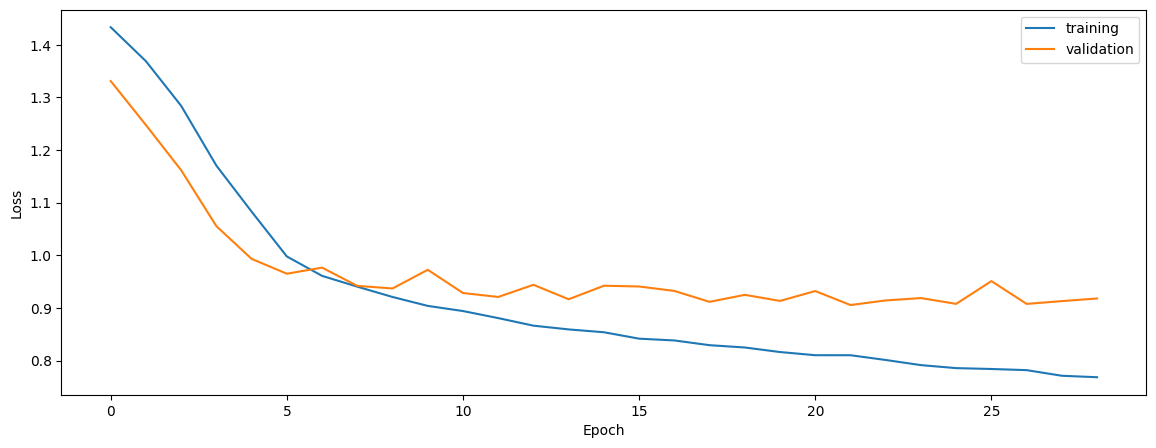

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


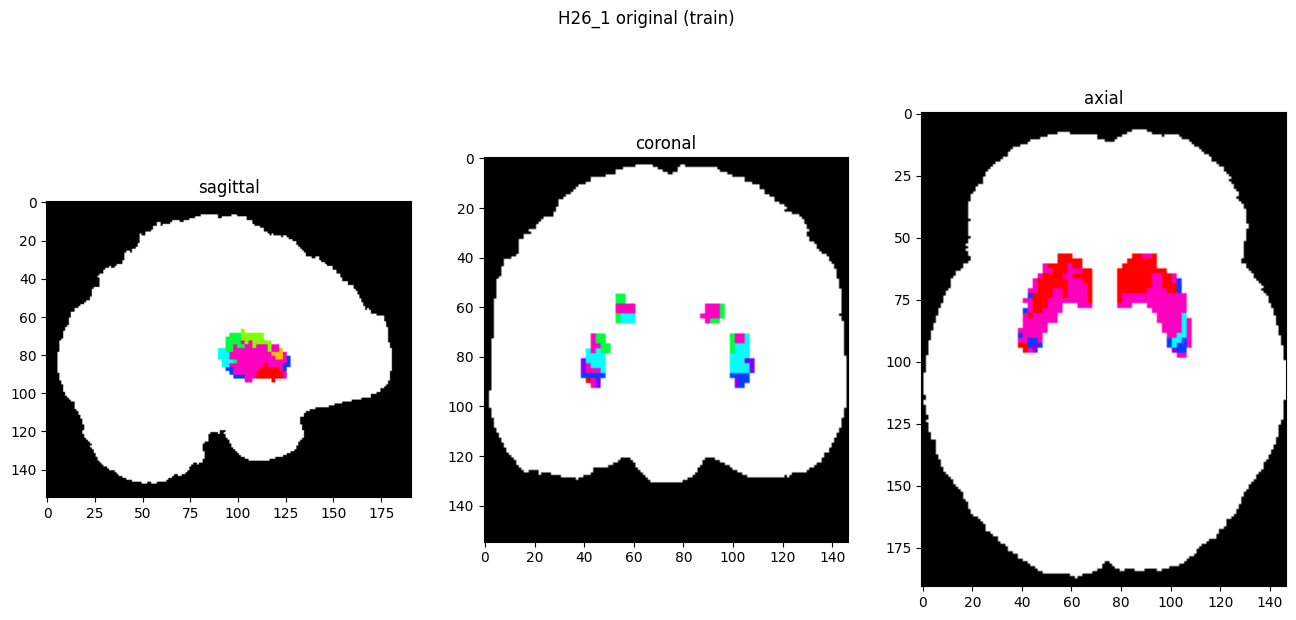

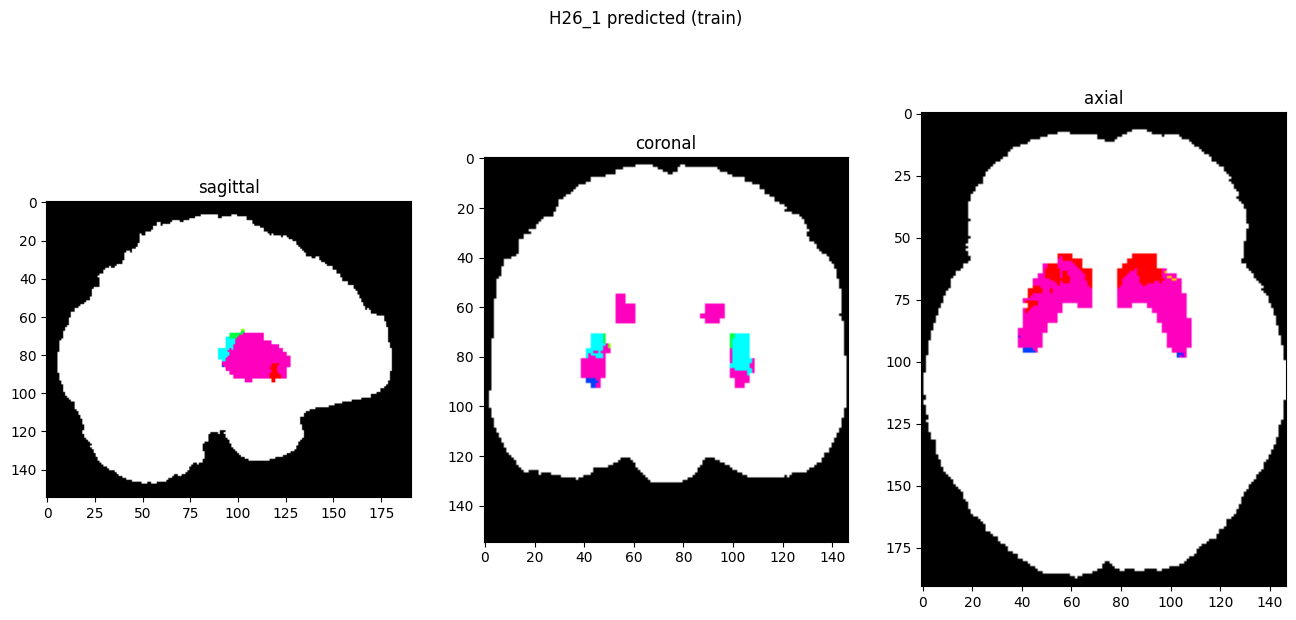

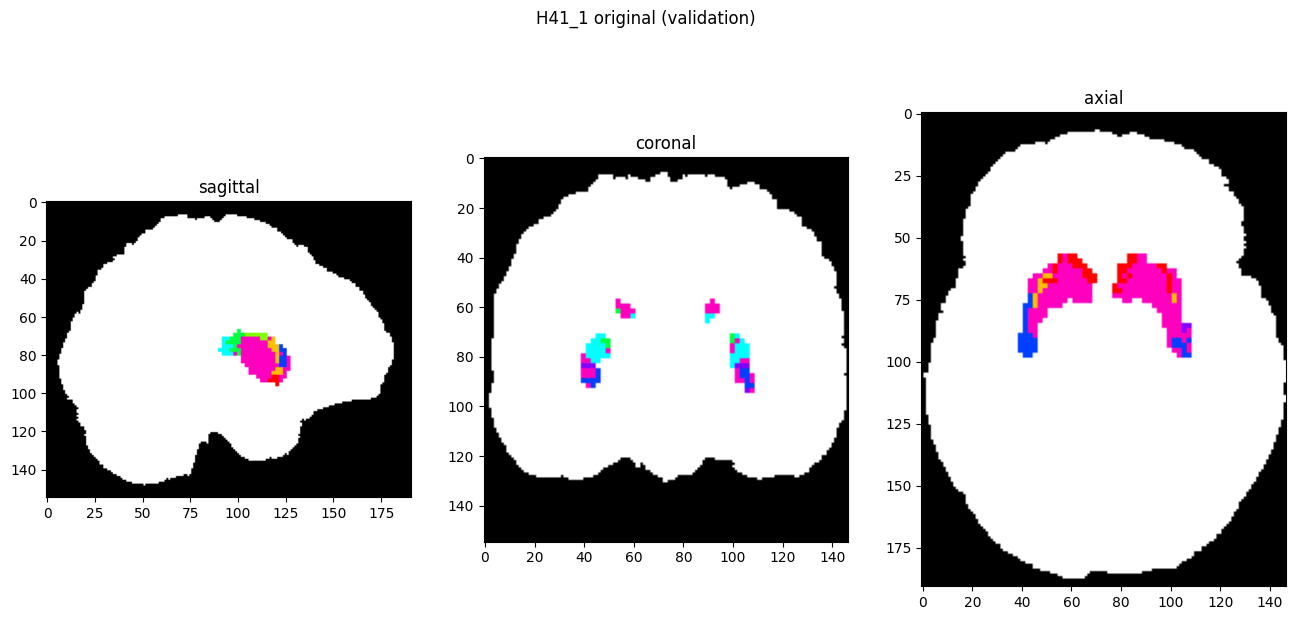

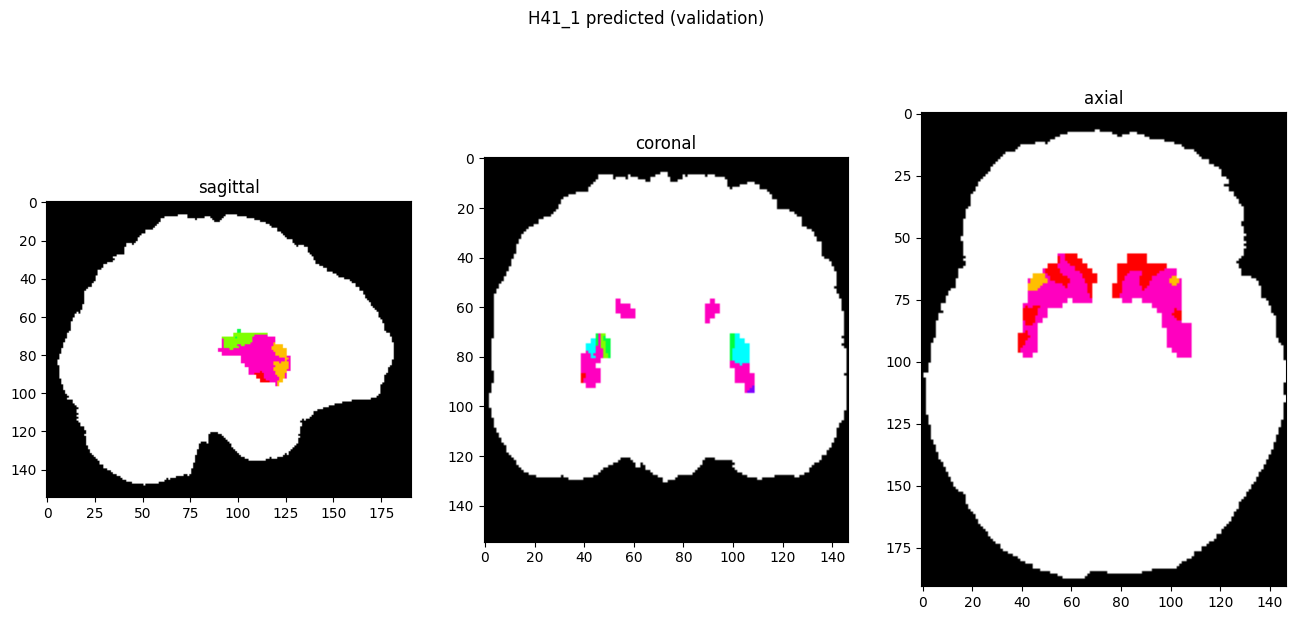

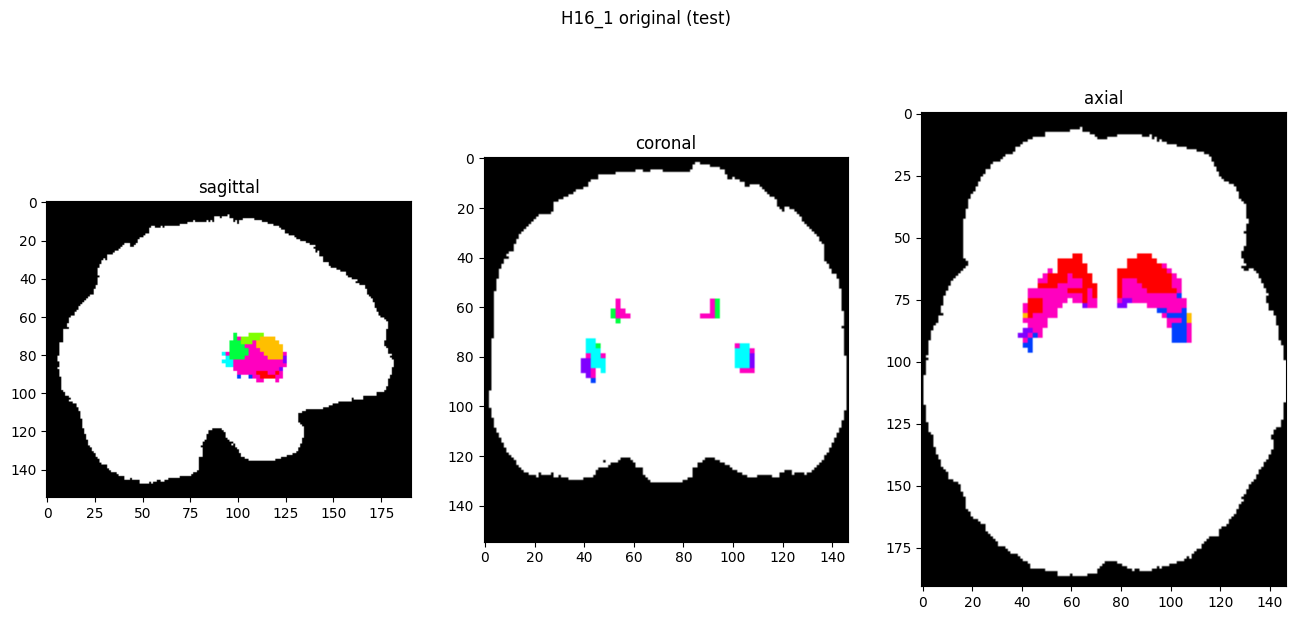

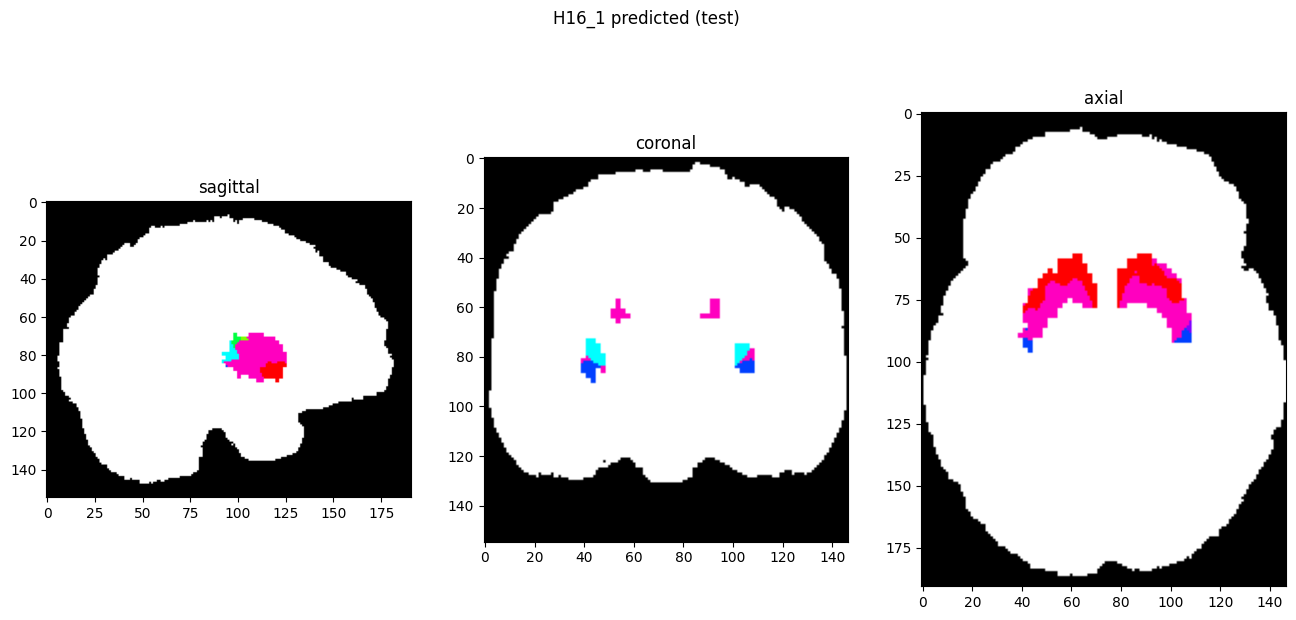

In [10]:
showResults(model, gen, threshold=0)